**What is Pneumonia?**

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

### Resize & Normalize images.

#### Import Libraries

In [31]:
import os
import collections
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

✅ **Phase 2: Preprocessing Images**

1. **Defined Paths** → For train/val/test folders.
2. **Data Generators** → Created with:
   - **Train**: Normalization + Augmentation (rotation, flip, zoom, etc.).
   - **Validation/Test**: Normalization only.
3. **Batch Generators** → Built train/val/test pipelines using `flow_from_directory()`.
4. **Checked Class Balance** → Printed how many images per class.
5. **Visualized Samples** → Displayed a few images with labels to confirm pipeline works.


In [32]:
# Define Dataset Paths

base_dir = "../input/chest-xray-pneumonia"

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

# Print directories
print("Train Directory:", train_dir)
print("Validation Directory:", val_dir)
print("Test Directory:", test_dir)

Train Directory: ../input/chest-xray-pneumonia/train
Validation Directory: ../input/chest-xray-pneumonia/val
Test Directory: ../input/chest-xray-pneumonia/test


In [33]:
# List of directories
directories = [train_dir, val_dir, test_dir]

# Delete .DS_Store directory from all paths
for directory in directories:
    ds_store_path = os.path.join(directory, ".DS_Store")
    if os.path.exists(ds_store_path):
        os.remove(ds_store_path)
        print(f".DS_Store deleted from {directory}")
    else:
        print(f"No .DS_Store found in {directory}")

No .DS_Store found in ../input/chest-xray-pneumonia/train
No .DS_Store found in ../input/chest-xray-pneumonia/val
No .DS_Store found in ../input/chest-xray-pneumonia/test


In [34]:
# Print contents of each folder
print("\nContents in Train Directory:", os.listdir(train_dir))
print("Contents in Validation Directory:", os.listdir(val_dir))
print("Contents in Test Directory:", os.listdir(test_dir))


Contents in Train Directory: ['PNEUMONIA', 'NORMAL']
Contents in Validation Directory: ['PNEUMONIA', 'NORMAL']
Contents in Test Directory: ['PNEUMONIA', 'NORMAL']


### Data Generators with Augmentation

In [35]:
# We’ll resize images to 224×224 (good for most CNNs).
# •	train_datagen → with augmentation.
# •	val_datagen & test_datagen → only normalization.

In [36]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,        # normalize pixels
    rotation_range=15,     # small rotations
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'   # Normal vs Pneumonia
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False   # for evaluation
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Check Class Balance

In [37]:
def count_images(directory):
    class_counts = {}
    for label in os.listdir(directory):
        folder = os.path.join(directory, label)
        class_counts[label] = len(os.listdir(folder))
    return class_counts

print("Train:", count_images(train_dir))
print("Test:", count_images(test_dir))
print("Validation:", count_images(val_dir))

Train: {'PNEUMONIA': 3875, 'NORMAL': 1341}
Test: {'PNEUMONIA': 390, 'NORMAL': 234}
Validation: {'PNEUMONIA': 8, 'NORMAL': 8}


⚠️ You’ll probably see imbalance: more Pneumonia images than Normal → that’s why we added augmentation.

 Visualize Some Images

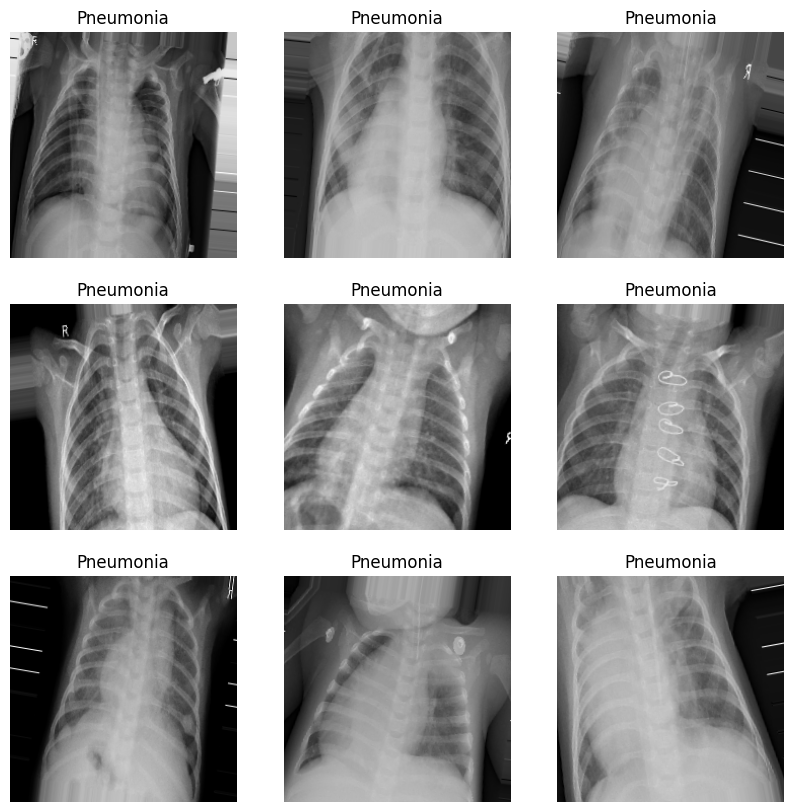

In [38]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title("Pneumonia" if y_batch[i] == 1 else "Normal")
    plt.axis("off")
plt.show()

data augmentation increases variation during training but does not permanently increase the number of images in train/test/val folders.

### **🔹 Phase 3: Baseline Model**

1. Import Libraries

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

2. Define Model Architecture

In [41]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

baseline_model = Sequential([
    Input(shape=(224,224,3)),                # 👈 Explicit Input layer
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


3. Compile the Model

In [42]:
baseline_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

4. Train the Model

In [43]:
EPOCHS = 10

history = baseline_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

/Users/pankajkumar/.local/share/virtualenvs/common_pycharm_venv-fp23ja/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-09-13 23:58:28.944793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 429ms/step - accuracy: 0.5905 - loss: 1.0600 - val_accuracy: 0.6250 - val_loss: 0.7479
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 305ms/step - accuracy: 0.7412 - loss: 0.9530 - val_accuracy: 0.6250 - val_loss: 1.4138
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 279ms/step - accuracy: 0.8035 - loss: 1.0631 - val_accuracy: 0.6250 - val_loss: 2.5319
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 275ms/step - accuracy: 0.8069 - loss: 1.0587 - val_accuracy: 0.6250 - val_loss: 2.9610
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 275ms/step - accuracy: 0.8163 - loss: 1.0023 - val_accuracy: 0.6250 - val_loss: 2.0451
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 275ms/step - accuracy: 0.8257 - loss: 0.8674 - val_accuracy: 0.6875 - val_loss: 1.3415
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 272ms/step - accuracy: 0.8349 - loss: 0.7482 - val_accuracy: 0.6875 - val_loss: 1.3802
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 282ms/step - accuracy: 0.8338 - loss: 0.7753 - val

5. Plot Training Curves

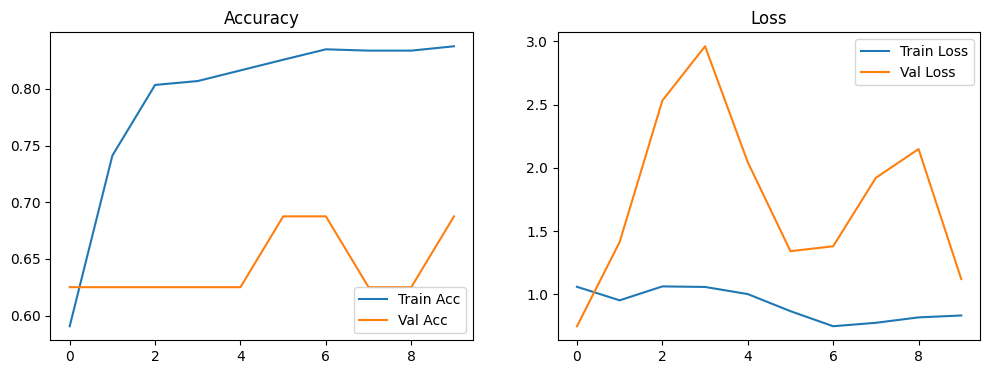

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()

6. Evaluate on Test Set

In [45]:
test_loss, test_acc = baseline_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8558 - loss: 0.5741
Test Accuracy: 0.8558


🔹 **Next Step (Before Transfer Learning)**

I suggest you now **analyze errors → see where the model misclassified**.
This will:

1. Show if the model is biased towards one class.
2. Confirm if imbalance is hurting predictions.

---

✅ Here’s quick code for **confusion matrix + classification report**:


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step


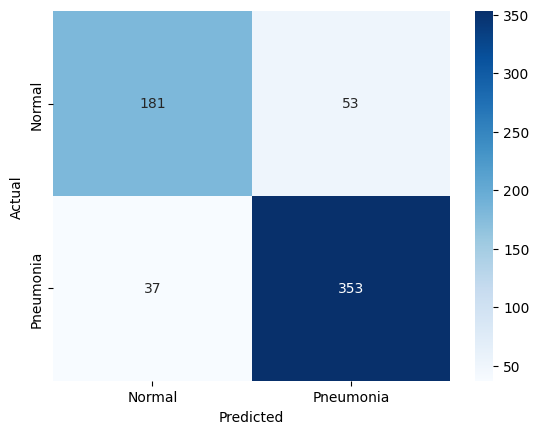

              precision    recall  f1-score   support

      Normal       0.83      0.77      0.80       234
   Pneumonia       0.87      0.91      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.84       624
weighted avg       0.85      0.86      0.85       624



In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = baseline_model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

# True labels
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=["Normal", "Pneumonia"]))

## 🔹 Phase 4: Transfer Learning (ResNet50)

🔹 **Next Step: Import Pretrained Model**

We’ll use **ResNet50 pretrained on ImageNet**.

Steps:
- Remove its top classifier.
- Add our custom dense layers for binary classification.


In [47]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base layers (initial training)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step


2. Compile Model

In [48]:
from tensorflow.keras.optimizers import Adam

resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
resnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

3. Train Model (Feature Extraction)

First, train only the new top layers.

In [49]:
EPOCHS = 5

history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 455ms/step - accuracy: 0.6881 - loss: 0.6702 - val_accuracy: 0.5000 - val_loss: 0.8754
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 448ms/step - accuracy: 0.7065 - loss: 0.6184 - val_accuracy: 0.5000 - val_loss: 0.8190
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 352ms/step - accuracy: 0.7078 - loss: 0.5951 - val_accuracy: 0.5000 - val_loss: 0.8552
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 355ms/step - accuracy: 0.7283 - loss: 0.5682 - val_accuracy: 0.5000 - val_loss: 0.7787
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 358ms/step - accuracy: 0.7326 - loss: 0.5536 - val_accuracy: 0.5000 - val_loss: 0.8009


4. Fine-Tuning (Unfreeze Some Layers)

After initial training, unfreeze last few layers of ResNet50 and continue training.

In [50]:
# Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # lower LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

EPOCHS_FINE = 10

history_finetune = resnet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS_FINE
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 570ms/step - accuracy: 0.8432 - loss: 0.4944 - val_accuracy: 0.5000 - val_loss: 0.7942
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 614ms/step - accuracy: 0.9003 - loss: 0.2329 - val_accuracy: 0.7500 - val_loss: 0.5199
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 634ms/step - accuracy: 0.9074 - loss: 0.2158 - val_accuracy: 0.7500 - val_loss: 0.3547
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 583ms/step - accuracy: 0.9206 - loss: 0.1982 - val_accuracy: 0.6875 - val_loss: 0.5088
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 572ms/step - accuracy: 0.9197 - loss: 0.1914 - val_accuracy: 0.8125 - val_loss: 0.6401
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 577ms/step - accuracy: 0.9239 - loss: 0.1846 - val_accuracy: 0.6250 - val_loss: 0.8333
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 577ms/step - accuracy: 0.9174 - loss: 0.1870 - val_accuracy: 0.8125 - val_loss: 0.2875
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 579ms/step - accuracy: 0.9283 - loss

5. Evaluate on Test Set

In [51]:
test_loss, test_acc = resnet_model.evaluate(test_generator)
print(f"Test Accuracy after Transfer Learning: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.8894 - loss: 0.3240
Test Accuracy after Transfer Learning: 0.8894


6. Plot Training Curves


(merge baseline + fine-tuning history if you want a combined plot)

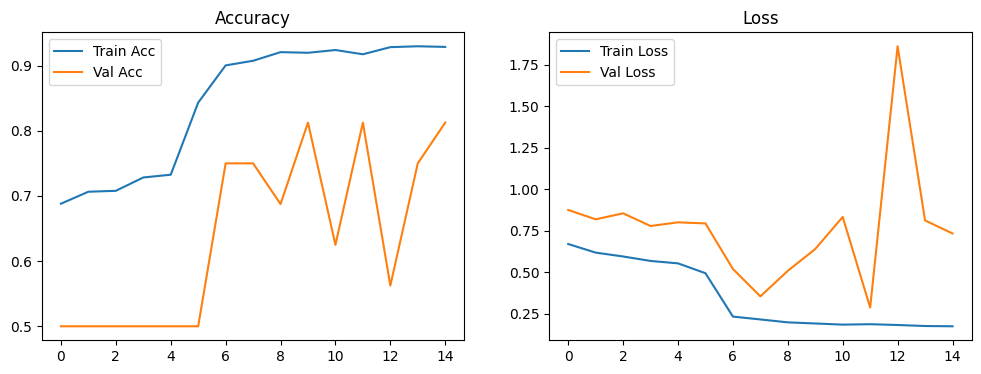

In [52]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'] + history_finetune.history['accuracy'], label='Train Acc')
plt.plot(history_resnet.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'] + history_finetune.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'] + history_finetune.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()

### 🔹 Phase 5: Grad-CAM for Explainability

1. Import Required Libraries

In [53]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

2. Grad-CAM Function

We’ll use the last convolutional layer of ResNet50 to extract activation maps.

In [60]:
def get_img_array(img_path, size=(224,224)):
    # Convert image to array
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array /= 255.0
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0–1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap   # <-- no .numpy()

3. Overlay Heatmap on Original Image

In [62]:
def display_gradcam(img_path, model, last_conv_layer_name="conv5_block3_out"):
    img_array = get_img_array(img_path)

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))

    # Apply heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Overlay")
    plt.axis("off")

    plt.show()

4. Test Grad-CAM on an Image


Pick a sample X-ray from your test set:

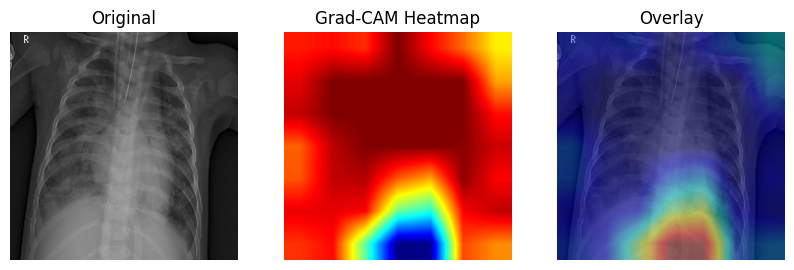

In [63]:
sample_img = "../input/chest-xray-pneumonia/test/PNEUMONIA/person80_bacteria_389.jpeg"
display_gradcam(sample_img, resnet_model)

✅ **Expected Outcome**

- For **Normal X-rays** → Grad-CAM will highlight empty lung areas.
- For **Pneumonia X-rays** → Heatmap will focus on infected lung patches.
- Overlay makes it **visually explainable** → a huge plus for your portfolio.


# 🔹 Phase 6: Model Evaluation

We’ll use:
- **Confusion Matrix** → Misclassification insight
- **Classification Report** → Precision, Recall, F1-score
- **ROC & AUC** → Medical reliability check
- **Precision-Recall Curve** → Important for imbalanced datasets


1. Import Evaluation Libraries

In [66]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns

2. Get Predictions on Test Set

In [68]:
# Get predicted probabilities
y_pred_probs = resnet_model.predict(test_generator, verbose=1)

# Convert to class labels (0 = Normal, 1 = Pneumonia)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

# True labels
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 609ms/step


3. Confusion Matrix

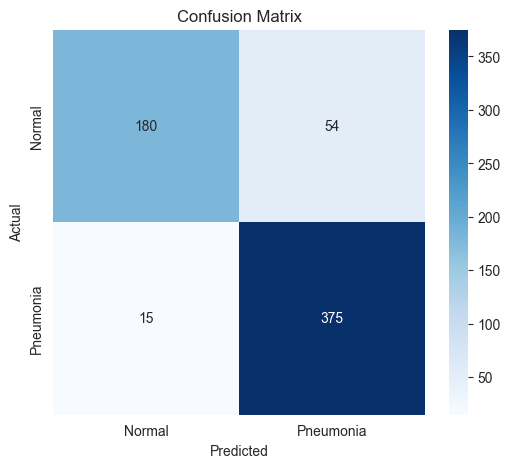

In [69]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

4. Classification Report

In [70]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))

Classification Report:

              precision    recall  f1-score   support

      Normal       0.92      0.77      0.84       234
   Pneumonia       0.87      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



5. ROC Curve & AUC

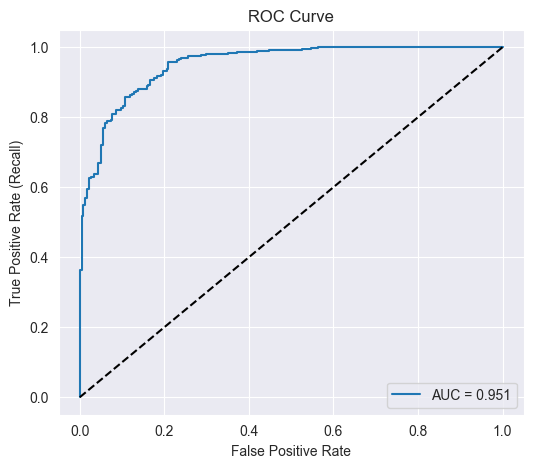

In [71]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

6. Precision-Recall Curve

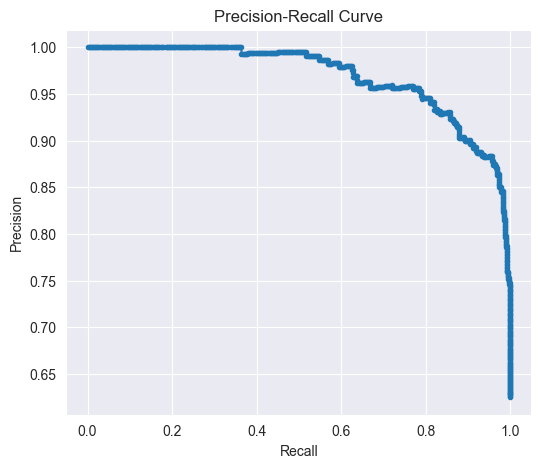

In [72]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

✅ **Expected Outcome**
- **Confusion Matrix** → Very few false negatives ideally
- **Classification Report** → Recall > 0.9 for Pneumonia
- **ROC-AUC** → ~0.95+ for medical-grade performance
- **PR Curve** → Balanced curve, not dropping too early


# Phase 7 — Save / Optimize model + FastAPI backend + React frontend

1) Save your trained model (Keras + SavedModel)

In [75]:
# Save in HDF5 format
resnet_model.save("../models/resnet_pneumonia.h5")

# Save in the new Keras v3 format (recommended for portability)
resnet_model.save("../models/resnet_pneumonia.keras")

# Save in TensorFlow SavedModel format (for conversion / serving)
resnet_model.export("../models/resnet_pneumonia_savedmodel")


INFO:tensorflow:Assets written to: ../models/resnet_pneumonia_savedmodel/assets


INFO:tensorflow:Assets written to: ../models/resnet_pneumonia_savedmodel/assets


Saved artifact at '../models/resnet_pneumonia_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_30')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  12975619920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12975615696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12975616464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12975616656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12975616080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12975614928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12975617232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12975614352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12975617040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12975618768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12975618576: TensorSpec(shape=